In [1]:
from chordextractor import ChordExtractor
import chordgraph

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.stats import itemfreq
import time
import os
import pickle
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import Lasso
%matplotlib inline 

## Functions to get vectors from MIDI files for chords, pitches and durations

In [2]:
# Get file names of type type_ in all the subdirectories of the path
def get_filenames(path, type_ = None):
    if type_ == None:
        return sum(map(lambda walks: (map(lambda name: os.path.join(walks[0], name),
                                                                           walks[2])), os.walk(path)), [])
    else:
        return filter(lambda f: f.endswith(type_), sum(map(lambda walks: (map(lambda name: os.path.join(walks[0], name),
                                                                           walks[2])), os.walk(path)), []))
       
# Getting set of all possible chords after normalization        
chord_encode =  {k: i for k, i in zip(chordgraph.ChordGraph().normalized_chords,
                                      range(len(chordgraph.ChordGraph().normalized_chords)))}        
        
# Enumerating chords for processing and storage optimization
def encode_chords(chords, encoder = None, type_ = None):
    if type_ == 'chord':
        return map(lambda chord: encoder[chord], chords)
    return chords

# Generate all sequences of 4 consecutive notes
def get_sequences(data):
    return map(lambda i: [data[i], data[i+1], data[i+2], data[i+3]], range(0, len(data)-3))

# Returns index of the note quartet in the vector
def notestoindex(numbers, num):
    return reduce(lambda x, y: num*x+y, numbers)

# Build vector of ocurrences of note quartets
def build_vector(sequence, num):
    vector = [0] * num**4
    seqs_indexed = map(notestoindex, sequence, [num]*len(sequence))
    for x in itemfreq(seqs_indexed):
        vector[x[0]] = x[1]
    return vector

def vector_from_file(filename_):
    extractor = ChordExtractor(filename_)
    chord_vector = build_vector(get_sequences(encode_chords(extractor.getNormalizedChords(), chord_encode, 'chord')),14)
    pitch_vector = build_vector(get_sequences(encode_chords(extractor.getNormalizedPitches())),12)
    return chord_vector, pitch_vector

#normalizedChords = extractor.getNormalizedChords()
#normalizedPitches = extractor.getNormalizedPitches()
# normalizedDurations = extractor.getChordDurations()

# Build vectors from MIDI files and pickle them
def vectors_from_files(path, class_, count):
    files = map(lambda x: x[0], sorted(map(lambda f: [f, os.stat(f).st_size], get_filenames(path)), 
                                   key = lambda x: x[1]))[:count]
    c = 0
    for name in files:
        try: 
            with open(str(class_)+str(c)+".dat", "wb") as f:
                pickle.dump(vector_from_file(name), f)
                print name+" done"
                print str(class_)+str(c)+".dat"
                c+=1
        except:
            print "Couldn't process " + name + " because Music 21 sucks."
    #X = map(lambda name: vector_from_file(name), files)
    return True

# Loading vectors from pickles
def get_vectors_from_pickles(path):
    class0 = filter(lambda x: x.split('/')[-1][0]=='0', get_filenames(path, ".dat"))
    class1 = filter(lambda x: x.split('/')[-1][0]=='1', get_filenames(path, ".dat"))
    class2 = filter(lambda x: x.split('/')[-1][0]=='2', get_filenames(path, ".dat"))
    class3 = filter(lambda x: x.split('/')[-1][0]=='3', get_filenames(path, ".dat"))
    vector0 = []
    vector1 = []
    vector2 = []
    vector3 = []
    for name in class0:
        with open(name, "rb") as f:
            vector0.append(pickle.load(f))
    for name in class1:
        with open(name, "rb") as f:
            vector1.append(pickle.load(f))
    for name in class2:
        with open(name, "rb") as f:
            vector2.append(pickle.load(f))
    for name in class3:
        with open(name, "rb") as f:
            vector3.append(pickle.load(f))
    return vector0, vector1, vector2, vector3

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Rename files, get vectors

In [ ]:
# path_to_class0 = './50s/'
# path_to_class1 = './60s/'
# # Renaming 50s and 60s .kar to .mid
# map1 = map(lambda name: os.rename(name, name.replace(".kar", ".mid").replace(".KAR", ".mid")), 
#            get_filenames(path_to_class0))
# map2 = map(lambda name: os.rename(name, name.replace(".kar", ".mid").replace(".KAR", ".mid")), 
#            get_filenames(path_to_class1))

# # Identifying the smallest directory in terms of number of midis
# midi_count = min(len(get_filenames(path_to_class0)), len(get_filenames(path_to_class1)))
# midi_count

In [ ]:
# start_time = time.time()
# vectors = vectors_from_files(path_to_class0, 3, 72)
# print "Class 3 is done"
# print("--- %s seconds ---" % (time.time() - start_time))
# vectors2 = vectors_from_files(path_to_class1, 2, 76)
# print "Class 2 is done"
# print("--- %s seconds ---" % (time.time() - start_time))

In [3]:
# Extraction of the features with maximal interclass variance
def feature_selector(vectors, percentile_):
    transposed = map(np.transpose, vectors)
    means = map(lambda t: map(np.mean, t), transposed)
    stds = map(lambda x: np.std(x), zip(*means))
    threshold = np.percentile(stds, percentile_)
    stds = zip(range(len(stds)), stds)
    index = map(lambda st: st[0], filter(lambda x: x[1] > threshold, stds))
    new_vectors = map(lambda vector: map(lambda v: map(lambda ind: v[ind], index), vector), vectors)
    return new_vectors

In [4]:
# Separating chords and pitches
vectors = get_vectors_from_pickles('vectors')
chords = map(lambda vector: map(lambda v: v[0], vector), vectors)
pitches = map(lambda vector: map(lambda v: v[1], vector), vectors)

In [5]:
new_chords = feature_selector(chords, 95)
new_pitches = feature_selector(pitches, 95)

# SVM

## Chords

In [6]:
# Building train, validation and test sets for each class
X = new_chords
Y = [[0]*72, [1]*72, [2]*72, [3]*72]

# Splitting the data into training and testing subsets 90 to 10 %
X_train0, X_test0, Y_train0, Y_test0 = train_test_split(X[0], Y[0], test_size = 0.1, random_state = 25)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X[1], Y[1], test_size = 0.1, random_state = 25)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X[2], Y[2], test_size = 0.1, random_state = 25)
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X[3], Y[3], test_size = 0.1, random_state = 25)

print len(X_train0), len(Y_train0)
print len(X_test0), len(Y_test0)

64 64
8 8


In [7]:
def fit_binary(X_A, X_B, Y_A, Y_B):
    # Merging the vectors together and extracting the attributes and the label
    X = X_A + X_B
    Y = Y_A + Y_B

    # Splitting the data into training and testing subsets 85 to 15 %
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.15, random_state = 25)


    # Function to train SVM on training set and to predict the validation set
    def trainpredict(degree, C):
        clf = svm.SVC(kernel = 'rbf', degree = degree, C = C, max_iter = 50000, shrinking=False) 
        clf.fit(X_train, Y_train)
        return (Y_valid == clf.predict(X_valid)).sum()*100/len(Y_valid), degree, C

    # Function to fit poly SVMs of degrees 1 to 4 each with Cs from the list
    def fitDegree_C():
        return map(lambda degree: map(trainpredict, [degree]*len(np.linspace(-10, 2*degree, 70)),
                                map(lambda c: math.exp(c), np.linspace(-10, 2*degree, 70))), range(1, 5)) 
    # Each of the sublists correspond to a degree (1 to 4) and has tuples with (accuracy, degree, C)
    fitted = fitDegree_C()

    # Finding the best fit
    flatten = sum(fitted, [])
    # Looking for the optimal parameters
    best_fit = max(enumerate(flatten), key = lambda x: x[1])
    clf = svm.SVC(kernel = 'rbf', degree = best_fit[1][1], C=best_fit[1][-1])
    clf.fit(X, Y)
    return best_fit, clf

In [8]:
best_fit_01, model_01 = fit_binary(X_train0, X_train1, Y_train0, Y_train1)
best_fit_02, model_02 = fit_binary(X_train0, X_train2, Y_train0, Y_train2)
best_fit_03, model_03 = fit_binary(X_train0, X_train3, Y_train0, Y_train3)
best_fit_12, model_12 = fit_binary(X_train1, X_train2, Y_train1, Y_train2)
best_fit_13, model_13 = fit_binary(X_train1, X_train3, Y_train1, Y_train3)
best_fit_23 ,model_23 = fit_binary(X_train2, X_train3, Y_train2, Y_train3)

In [9]:
models = [model_01, model_02, model_03, model_12, model_13, model_23]
fits = [best_fit_01[1][0], best_fit_02[1][0], best_fit_03[1][0], best_fit_12[1][0], 
           best_fit_13[1][0], best_fit_23[1][0]]
support_vectors = [model_01.support_vectors_, model_02.support_vectors_, model_03.support_vectors_, 
                   model_12.support_vectors_, model_13.support_vectors_, model_23.support_vectors_]
fits

[100, 80, 80, 100, 100, 45]

In [42]:
# def get_model_index(point, means):
#     distances = map(lambda mean_: np.linalg.norm(np.asarray(point) - np.asarray(mean_)), means)
#     return sorted(zip(range(len(distances)), distances), key = lambda x: x[1])

# def predict_one(point, means):
#     index = get_model_index(point, means)
#     return map(lambda ind: models[ind[0]].predict([point])[0], index)

# def get_predictions(data, support_vectors):
#     means = map(lambda support: sum(map(lambda t: map(np.median, t), map(np.transpose, [support])), []), support_vectors)
#     return map(predict_one, data, [means]*len(data))
# #    return predictions

# #def prediction_0(data):
# #    return map(models[pick_model].predict, data)


In [12]:
#model_01.n_support_

In [10]:
#means = map(lambda support: sum(map(lambda t: map(np.mean, t), map(np.transpose, [support])), []), support_vectors)
#yy = np.asarray(get_predictions(X_test, support_vectors))
#zip(Y_test, yy, predictions_test)

In [11]:
#print "We successfully predict {} percent of test data".format((Y_test==yy).sum()*100/len(Y_test))

In [16]:
def prediction(data):
    cnt = np.bincount(map(lambda m: m.predict([data])[0], models))
    return max(zip(range(len(cnt)), cnt), key = lambda x: x[1])[0]

In [17]:
X_train = X_train0 + X_train1 + X_train2 + X_train3
Y_train = Y_train0 + Y_train1 + Y_train2 + Y_train3
X_test = X_test0 + X_test1 + X_test2 + X_test3
Y_test = Y_test0 + Y_test1 + Y_test2 + Y_test3
predictions_train = np.asarray(map(prediction, X_train))
predictions_test = np.asarray(map(prediction, X_test))

In [18]:
print "We successfully predict {} percent of train data".format((Y_train==predictions_train).sum()*100/len(Y_train))
print "We successfully predict {} percent of test data".format((Y_test==predictions_test).sum()*100/len(Y_test))

We successfully predict 100 percent of train data
We successfully predict 75 percent of test data


In [19]:
# def plotter(a):
#     fig = plt.figure(figsize=(10, 8))
#     fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
#     for i in range (1, 5):
#         ax = fig.add_subplot(2, 2, i)
#         ax.set_title("Polynomial degree of " + str(i+a))
#         ax.set_ylabel("Accuracy")
#         ax.set_xlabel("C")
#         ax.semilogx()
#         plot_ = plt.plot(map(lambda x: x[2], fitted[i+a-1]), map(lambda x: x[0], fitted[i+a-1]))
#     return True

# p = plotter(0)

In [20]:
# p = plotter(4)

Confusion matrix, without normalization


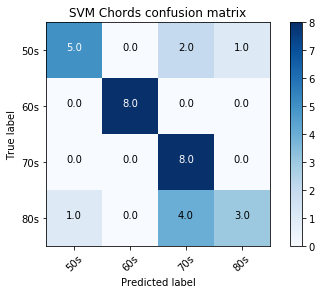

In [21]:
# Confusion matrix
Y_test
Y_predict = predictions_test
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['50s', '60s', '70s', '80s'], normalize=False,
                      title='SVM Chords confusion matrix')

Normalized confusion matrix


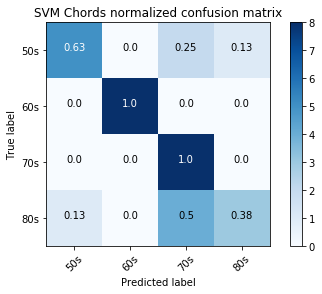

In [22]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['50s', '60s', '70s', '80s'], normalize=True,
                      title='SVM Chords normalized confusion matrix')

# SVM 

## Pitches

In [31]:
# Building train, validation and test sets for each class
X = new_pitches
Y = [[0]*72, [1]*72, [2]*72, [3]*72]

# Splitting the data into training and testing subsets 90 to 10 %
X_train0, X_test0, Y_train0, Y_test0 = train_test_split(X[0], Y[0], test_size = 0.1, random_state = 25)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X[1], Y[1], test_size = 0.1, random_state = 25)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X[2], Y[2], test_size = 0.1, random_state = 25)
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X[3], Y[3], test_size = 0.1, random_state = 25)

print len(X_train0), len(Y_train0)
print len(X_test0), len(Y_test0)

64 64
8 8


In [32]:
best_fit_01, model_01 = fit_binary(X_train0, X_train1, Y_train0, Y_train1)
best_fit_02, model_02 = fit_binary(X_train0, X_train2, Y_train0, Y_train2)
best_fit_03, model_03 = fit_binary(X_train0, X_train3, Y_train0, Y_train3)
best_fit_12, model_12 = fit_binary(X_train1, X_train2, Y_train1, Y_train2)
best_fit_13, model_13 = fit_binary(X_train1, X_train3, Y_train1, Y_train3)
best_fit_23 ,model_23 = fit_binary(X_train2, X_train3, Y_train2, Y_train3)

In [33]:
models = [model_01, model_02, model_03, model_12, model_13, model_23]
fits = [best_fit_01[1][0], best_fit_02[1][0], best_fit_03[1][0], best_fit_12[1][0], 
           best_fit_13[1][0], best_fit_23[1][0]]
support_vectors = [model_01.support_vectors_, model_02.support_vectors_, model_03.support_vectors_, 
                   model_12.support_vectors_, model_13.support_vectors_, model_23.support_vectors_]
fits

[100, 65, 65, 100, 100, 40]

In [34]:
X_train = X_train0 + X_train1 + X_train2 + X_train3
Y_train = Y_train0 + Y_train1 + Y_train2 + Y_train3
X_test = X_test0 + X_test1 + X_test2 + X_test3
Y_test = Y_test0 + Y_test1 + Y_test2 + Y_test3
predictions_train = np.asarray(map(prediction, X_train))
predictions_test = np.asarray(map(prediction, X_test))
print "We successfully predict {} percent of train data".format((Y_train==predictions_train).sum()*100/len(Y_train))
print "We successfully predict {} percent of test data".format((Y_test==predictions_test).sum()*100/len(Y_test))

We successfully predict 100 percent of train data
We successfully predict 71 percent of test data


In [36]:
#p = plotter(0)

In [26]:
#p = plotter(4)

Confusion matrix, without normalization


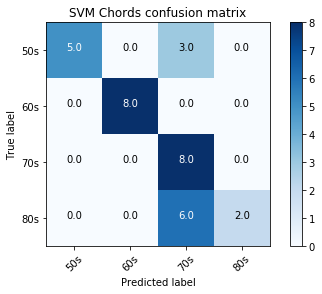

In [38]:
# Confusion matrix
Y_test
Y_predict = predictions_test
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['50s', '60s', '70s', '80s'], normalize=False,
                      title='SVM Chords confusion matrix')

Normalized confusion matrix


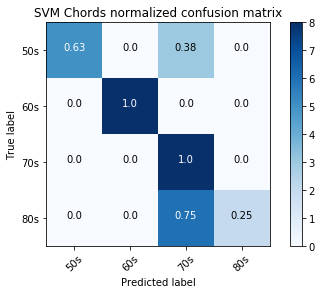

In [39]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['50s', '60s', '70s', '80s'], normalize=True,
                      title='SVM Chords normalized confusion matrix')

# Linear Regression LASSO

## Chords

In [40]:
# Building train, validation and test sets for each class
X = new_chords
Y = [[0]*72, [1]*72, [2]*72, [3]*72]

# Splitting the data into training and testing subsets 90 to 10 %
X_train0, X_test0, Y_train0, Y_test0 = train_test_split(X[0], Y[0], test_size = 0.1, random_state = 25)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X[1], Y[1], test_size = 0.1, random_state = 25)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X[2], Y[2], test_size = 0.1, random_state = 25)
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X[3], Y[3], test_size = 0.1, random_state = 25)

print len(X_train0), len(Y_train0)
print len(X_test0), len(Y_test0)

64 64
8 8


In [55]:
def fit_binary(X_A, X_B, Y_A, Y_B):
    # Merging the vectors together and extracting the attributes and the label
    X = X_A + X_B
    Y = Y_A + Y_B

    # Splitting the data into training and testing subsets 85 to 15 %
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.15, random_state = 25)


    # Function to train LASSO on training set and to predict the validation set
    def trainpredict_L(alpha):
        lassoreg = Lasso(alpha = alpha, normalize = False, max_iter = 1e5)
        lassoreg.fit(X_train, Y_train)
        Y_predict = abs(np.round(lassoreg.predict(X_valid)))
        return (Y_valid == Y_predict).sum()*100/len(Y_valid), alpha

    # Function to fit alpha for LASSO
    def fitalpha():
        return map(lambda alpha: trainpredict_L(alpha), np.linspace(0.0001, 10, 100))
    # Each of the sublists correspond to a degree (1 to 4) and has tuples with (accuracy, degree, C)
    
    # Fitting the alpha
    fitted = fitalpha()

    # Finding the best fit
    # Looking for the optimal parameters
    alpha = max(enumerate(fitted), key = lambda x: x[1])
    alpha[1][1]
    
    # Checkng on the test set
    lassoreg = Lasso(alpha = alpha[1][1], normalize = False, max_iter = 1e5)
    lassoreg.fit(X_train, Y_train)
    return alpha, lassoreg

def cutoff(a):
    if a>3:
        return 3
    if a<0:
        return 0
    return a

In [43]:
best_fit_01, model_01 = fit_binary(X_train0, X_train1, Y_train0, Y_train1)
best_fit_02, model_02 = fit_binary(X_train0, X_train2, Y_train0, Y_train2)
best_fit_03, model_03 = fit_binary(X_train0, X_train3, Y_train0, Y_train3)
best_fit_12, model_12 = fit_binary(X_train1, X_train2, Y_train1, Y_train2)
best_fit_13, model_13 = fit_binary(X_train1, X_train3, Y_train1, Y_train3)
best_fit_23 ,model_23 = fit_binary(X_train2, X_train3, Y_train2, Y_train3)

In [45]:
models = [model_01, model_02, model_03, model_12, model_13, model_23]
fits = [best_fit_01[1][0], best_fit_02[1][0], best_fit_03[1][0], best_fit_12[1][0], 
           best_fit_13[1][0], best_fit_23[1][0]]
fits

[85, 65, 30, 90, 65, 75]

In [56]:
def prediction(data):
    cnt = np.bincount(map(lambda m: cutoff(m.predict([data]))[0], models))
    return max(zip(range(len(cnt)), cnt), key = lambda x: x[1])[0]

In [57]:
X_train = X_train0 + X_train1 + X_train2 + X_train3
Y_train = Y_train0 + Y_train1 + Y_train2 + Y_train3
X_test = X_test0 + X_test1 + X_test2 + X_test3
Y_test = Y_test0 + Y_test1 + Y_test2 + Y_test3
predictions_train = np.asarray(map(prediction, X_train))
predictions_test = np.asarray(map(prediction, X_test))

TypeError: 'int' object has no attribute '__getitem__'

In [67]:
# Checkng on the test set
lassoreg = Lasso(alpha = alpha[1][1], normalize = False, max_iter = 1e5)
lassoreg.fit(X_train, Y_train)
predict_train = np.asarray(map(cutoff, abs(np.round(lassoreg.predict(X_train)))))
predict_test = np.asarray(map(cutoff, abs(np.round(lassoreg.predict(X_test)))))
print "We successfully predict the {} percent of training data".format((Y_train==predict_train).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==predict_test).sum()*100/len(Y_test))

We successfully predict the 100 percent of training data
We successfully predict the 55 percent of test data


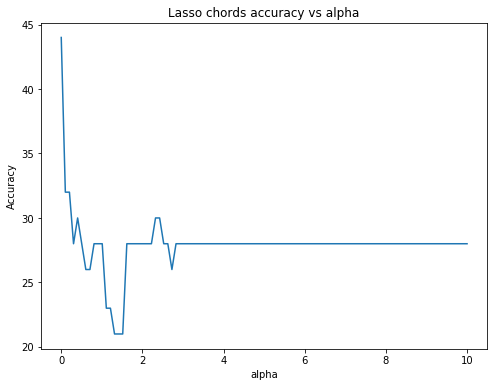

In [68]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Lasso chords accuracy vs alpha")
plot_ = plt.plot(map(lambda x: x[1], fitted), map(lambda x: x[0], fitted))

Confusion matrix, without normalization


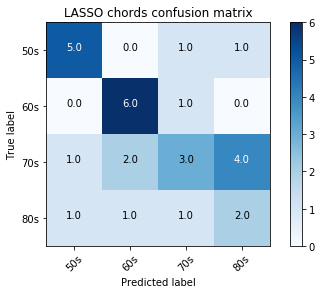

In [69]:
# Confusion matrix
Y_test
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, predict_test), classes=['50s', '60s', '70s', '80s'], normalize=False,
                      title='LASSO chords confusion matrix')

Normalized confusion matrix


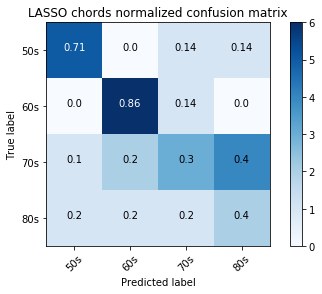

In [70]:
plot_confusion_matrix(confusion_matrix(Y_test, predict_test), classes=['50s', '60s', '70s', '80s'], normalize=True,
                      title='LASSO chords normalized confusion matrix')

# Linear Regression LASSO

## Pithces

In [71]:
# Merging the vectors together and extracting the attributes and the label
X = chordvector0_+chordvector1_+chordvector2_+chordvector3_
Y = [0]*72+[1]*72+[2]*72+[3]*72

# Splitting the data into training and testing subsets 85 to 15 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 25)

# Splitting the training subset into training and validating subsets 80 to 20 %
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state = 25)

print len(X_train), len(Y_train)
print len(X_valid), len(Y_valid)
print len(X_test), len(Y_test)

207 207
52 52
29 29


In [72]:
# Fitting the alpha
fitted = fitalpha()
# Looking for the optimal parameters
alpha = max(enumerate(fitted), key = lambda x: x[1])
alpha[1][1]

0.0001

In [73]:
# Checkng on the test set
lassoreg = Lasso(alpha = alpha[1][1], normalize = False, max_iter = 1e5)
lassoreg.fit(X_train, Y_train)
predict_train = np.asarray(map(cutoff, abs(np.round(lassoreg.predict(X_train)))))
predict_test = np.asarray(map(cutoff, abs(np.round(lassoreg.predict(X_test)))))
print "We successfully predict the {} percent of training data".format((Y_train==predict_train).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==predict_test).sum()*100/len(Y_test))

We successfully predict the 100 percent of training data
We successfully predict the 55 percent of test data


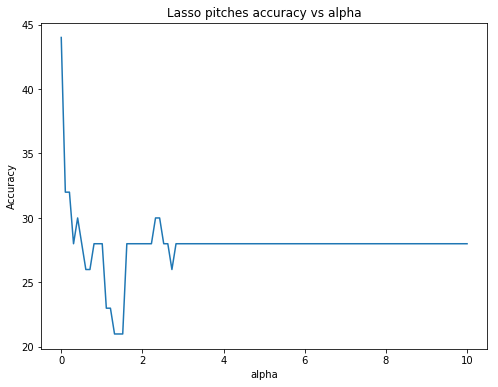

In [74]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Lasso pitches accuracy vs alpha")
plot_ = plt.plot(map(lambda x: x[1], fitted), map(lambda x: x[0], fitted))

Confusion matrix, without normalization


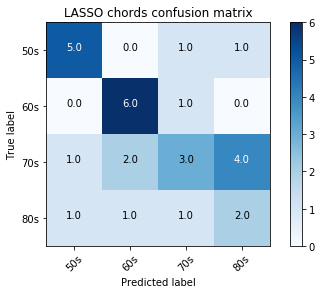

In [75]:
# Confusion matrix
Y_test
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, predict_test), classes=['50s', '60s', '70s', '80s'], normalize=False,
                      title='LASSO chords confusion matrix')

Normalized confusion matrix


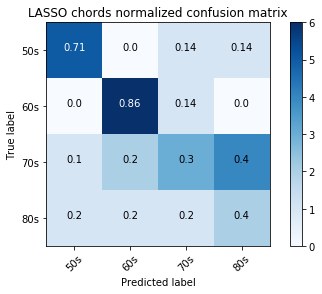

In [76]:
plot_confusion_matrix(confusion_matrix(Y_test, predict_test), classes=['50s', '60s', '70s', '80s'], normalize=True,
                      title='LASSO chords normalized confusion matrix')

# N-tuples

## Chords

In [86]:
chmax = sum(chstd)
ptmax = sum(ptstd)
chstd = map(lambda x: 1.0*x/chmax, chstd)
ptstd = map(lambda x: 1.0*x/ptmax, ptstd)

In [89]:
from ntuple import classify

In [90]:
# Merging the vectors together and extracting the attributes and the label
X = chordvector0_+chordvector1_+chordvector2_+chordvector3_
Y = [0]*72+[1]*72+[2]*72+[3]*72

# Splitting the data into training and testing subsets 85 to 15 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 25)

# Splitting the training subset into training and validating subsets 80 to 20 %
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.15, random_state = 25)

print len(X_train), len(Y_train)
print len(X_valid), len(Y_valid)
print len(X_test), len(Y_test)

220 220
39 39
29 29


In [91]:
# weights 
print chstd[:5]

[0.042749570425919634, 0.0033719764747464171, 0.0011352422521344488, 0.0014527224148313117, 0.0013127319680140052]
